In [97]:
# Install packages for project
# This has been commented as these packages have already been installed.

# %pip install pandas
# %pip install deep-translator
# %pip install google_trans_new
# %pip install google-cloud-translate==2.0.1
# %pip install trrex
# %pip install vaderSentiment


#Importing libraries

import glob
import pandas as pd
import numpy as np
from pandas import read_csv
from deep_translator import GoogleTranslator
from nltk import word_tokenize
import re
from collections import Counter
import eli5 as e5
import nltk
import csv
from nltk.corpus import stopwords
import pandas as pd
import trrex as tx
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA

nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/michaelmoor/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelmoor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [98]:
# small function to easily read text files

def read_txt(file_path, delimiter=None):
    content = ' '
    with open(file_path) as f:
        content = f.read().splitlines()

    if delimiter != None:
        content = content.split(delimiter)
    return content

In [99]:
# read csv file

csv = pd.read_csv ('./data/McDonalds-Yelp-Sentiment-DFE.csv', encoding="latin-1", on_bad_lines='skip', delimiter = ',')
opinion_words = read_txt('./data/opinion-lexicon-English/opinion-words.txt')
positive_words = read_txt('./data/opinion-lexicon-English/positive-words.txt')
negative_words = read_txt('./data/opinion-lexicon-English/negative-words.txt')
colums = csv.columns
print(colums)

csv.head(5)

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'policies_violated',
       'policies_violated:confidence', 'city', 'policies_violated_gold',
       'review'],
      dtype='object')


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,policies_violated,policies_violated:confidence,city,policies_violated_gold,review
0,679455653,False,finalized,3,2/21/15 0:36,RudeService\rOrderProblem\rFilthy,1.0\r0.6667\r0.6667,Atlanta,NaN,"I'm not a huge mcds lover, but I've been to be..."
1,679455654,False,finalized,3,2/21/15 0:27,RudeService,1,Atlanta,NaN,Terrible customer service. Î¾I came in at 9:30...
2,679455655,False,finalized,3,2/21/15 0:26,SlowService\rOrderProblem,1.0\r1.0,Atlanta,NaN,"First they ""lost"" my order, actually they gave..."
3,679455656,False,finalized,3,2/21/15 0:27,na,0.6667,Atlanta,NaN,I see I'm not the only one giving 1 star. Only...
4,679455657,False,finalized,3,2/21/15 0:27,RudeService,1,Atlanta,NaN,"Well, it's McDonald's, so you know what the fo..."


In [100]:
# Remove special characters and stopwords

stop = stopwords.words('english')
csv["review"] = csv["review"].apply(lambda x: " ".join(x.lower() for x in str(x).split() if x not in stop))

csv["review"] = csv["review"].map(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x))
csv.head(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,policies_violated,policies_violated:confidence,city,policies_violated_gold,review
0,679455653,False,finalized,3,2/21/15 0:36,RudeService\rOrderProblem\rFilthy,1.0\r0.6667\r0.6667,Atlanta,NaN,im huge mcds lover ive better ones this far wo...
1,679455654,False,finalized,3,2/21/15 0:27,RudeService,1,Atlanta,NaN,terrible customer service i came 930pm stood f...
2,679455655,False,finalized,3,2/21/15 0:26,SlowService\rOrderProblem,1.0\r1.0,Atlanta,NaN,first lost order actually gave someone one els...
3,679455656,False,finalized,3,2/21/15 0:27,na,0.6667,Atlanta,NaN,i see im one giving 1 star only 25 star thats ...
4,679455657,False,finalized,3,2/21/15 0:27,RudeService,1,Atlanta,NaN,well mcdonalds know food is this review reflec...


In [101]:
# Tokenize the reviews and add them as a seperate column
csv['tokenized-review'] = csv['review'].apply(lambda x : nltk.word_tokenize(x))
csv['policies_violated'] = csv['policies_violated'].apply(lambda x : re.split('\r', str(x)))
csv['policies_violated:confidence'] = csv['policies_violated:confidence'].apply(lambda x : [float(x.strip(' []')) for x in re.split('\r', str(x))])

csv['tokenized-review'].head(5)

0    [im, huge, mcds, lover, ive, better, ones, thi...
1    [terrible, customer, service, i, came, 930pm, ...
2    [first, lost, order, actually, gave, someone, ...
3    [i, see, im, one, giving, 1, star, only, 25, s...
4    [well, mcdonalds, know, food, is, this, review...
Name: tokenized-review, dtype: object

In [102]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
csv['compound'] = [analyzer.polarity_scores(x)['compound'] for x in         
csv["review"]]
csv['neg'] = [analyzer.polarity_scores(x)['neg'] for x in         
csv["review"]]
csv['neu'] = [analyzer.polarity_scores(x)['neu'] for x in         
csv["review"]]
csv['pos'] = [analyzer.polarity_scores(x)['pos'] for x in         
csv["review"]]

csv

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,policies_violated,policies_violated:confidence,city,policies_violated_gold,review,tokenized-review,compound,neg,neu,pos
0,679455653,False,finalized,3,2/21/15 0:36,"[RudeService, OrderProblem, Filthy]","[1.0, 0.6667, 0.6667]",Atlanta,NaN,im huge mcds lover ive better ones this far wo...,"[im, huge, mcds, lover, ive, better, ones, thi...",0.0790,0.253,0.488,0.259
1,679455654,False,finalized,3,2/21/15 0:27,[RudeService],[1.0],Atlanta,NaN,terrible customer service i came 930pm stood f...,"[terrible, customer, service, i, came, 930pm, ...",-0.7430,0.192,0.725,0.083
2,679455655,False,finalized,3,2/21/15 0:26,"[SlowService, OrderProblem]","[1.0, 1.0]",Atlanta,NaN,first lost order actually gave someone one els...,"[first, lost, order, actually, gave, someone, ...",-0.7351,0.132,0.815,0.053
3,679455656,False,finalized,3,2/21/15 0:27,[na],[0.6667],Atlanta,NaN,i see im one giving 1 star only 25 star thats ...,"[i, see, im, one, giving, 1, star, only, 25, s...",0.3400,0.000,0.844,0.156
4,679455657,False,finalized,3,2/21/15 0:27,[RudeService],[1.0],Atlanta,NaN,well mcdonalds know food is this review reflec...,"[well, mcdonalds, know, food, is, this, review...",0.8934,0.106,0.665,0.229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1520,679500008,False,finalized,3,2/21/15 0:13,[OrderProblem],[0.6754],Portland,NaN,i enjoyed part i repeatedly asked i right sauc...,"[i, enjoyed, part, i, repeatedly, asked, i, ri...",0.7311,0.000,0.661,0.339
1521,679500224,False,finalized,3,2/21/15 0:27,"[SlowService, Filthy, BadFood]","[1.0, 1.0, 1.0]",Houston,NaN,worst mcdonalds ive long time dirt everywhere ...,"[worst, mcdonalds, ive, long, time, dirt, ever...",-0.7579,0.351,0.649,0.000
1522,679500608,False,finalized,3,2/21/15 0:24,[ScaryMcDs],[0.6458],New York,NaN,when i really craving mcdonalds seems closest ...,"[when, i, really, craving, mcdonalds, seems, c...",0.8885,0.000,0.747,0.253
1523,679501257,False,finalized,3,2/21/15 0:32,[ScaryMcDs],[0.6407],Chicago,NaN,two points right gate 1 thuggery knows race li...,"[two, points, right, gate, 1, thuggery, knows,...",-0.8627,0.109,0.819,0.072


In [103]:
# categorize reviews as expected negatieve or positive

csv['evaluation'] = csv[['neg','pos']].idxmax(axis=1)

print(csv['evaluation'].value_counts())
csv.head(5)

pos    768
neg    757
Name: evaluation, dtype: int64


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,policies_violated,policies_violated:confidence,city,policies_violated_gold,review,tokenized-review,compound,neg,neu,pos,evaluation
0,679455653,False,finalized,3,2/21/15 0:36,"[RudeService, OrderProblem, Filthy]","[1.0, 0.6667, 0.6667]",Atlanta,NaN,im huge mcds lover ive better ones this far wo...,"[im, huge, mcds, lover, ive, better, ones, thi...",0.0790,0.253,0.488,0.259,pos
1,679455654,False,finalized,3,2/21/15 0:27,[RudeService],[1.0],Atlanta,NaN,terrible customer service i came 930pm stood f...,"[terrible, customer, service, i, came, 930pm, ...",-0.7430,0.192,0.725,0.083,neg
2,679455655,False,finalized,3,2/21/15 0:26,"[SlowService, OrderProblem]","[1.0, 1.0]",Atlanta,NaN,first lost order actually gave someone one els...,"[first, lost, order, actually, gave, someone, ...",-0.7351,0.132,0.815,0.053,neg
3,679455656,False,finalized,3,2/21/15 0:27,[na],[0.6667],Atlanta,NaN,i see im one giving 1 star only 25 star thats ...,"[i, see, im, one, giving, 1, star, only, 25, s...",0.3400,0.000,0.844,0.156,pos
4,679455657,False,finalized,3,2/21/15 0:27,[RudeService],[1.0],Atlanta,NaN,well mcdonalds know food is this review reflec...,"[well, mcdonalds, know, food, is, this, review...",0.8934,0.106,0.665,0.229,pos


In [104]:
# This data set does not contain golden reviews, hence we can drop these columns as we are not interested.

print(csv[['_golden']].value_counts())

# Dropping columns that are not usefull and create new dataframe reviews

reviews = csv.drop(columns=['_unit_id', '_golden', '_last_judgment_at', 'policies_violated_gold', '_unit_state'], axis=1)

reviews.head(5)

_golden
False      1525
dtype: int64


,_trusted_judgments,policies_violated,policies_violated:confidence,city,review,tokenized-review,compound,neg,neu,pos,evaluation
0,3,"[RudeService, OrderProblem, Filthy]","[1.0, 0.6667, 0.6667]",Atlanta,im huge mcds lover ive better ones this far wo...,"[im, huge, mcds, lover, ive, better, ones, thi...",0.0790,0.253,0.488,0.259,pos
1,3,[RudeService],[1.0],Atlanta,terrible customer service i came 930pm stood f...,"[terrible, customer, service, i, came, 930pm, ...",-0.7430,0.192,0.725,0.083,neg
2,3,"[SlowService, OrderProblem]","[1.0, 1.0]",Atlanta,first lost order actually gave someone one els...,"[first, lost, order, actually, gave, someone, ...",-0.7351,0.132,0.815,0.053,neg
3,3,[na],[0.6667],Atlanta,i see im one giving 1 star only 25 star thats ...,"[i, see, im, one, giving, 1, star, only, 25, s...",0.3400,0.000,0.844,0.156,pos
4,3,[RudeService],[1.0],Atlanta,well mcdonalds know food is this review reflec...,"[well, mcdonalds, know, food, is, this, review...",0.8934,0.106,0.665,0.229,pos


In [105]:
# Helper function to check if items in list are present in comparison list
def match_strings(original_list, comparison_list):
    content = []
    for token in original_list:
        if token in comparison_list:
            content.append(token)
    return content

In [106]:
reviews['opinion_words'] = [match_strings(x, opinion_words) for x in reviews['tokenized-review']]
reviews['positive_opinion_words'] = [match_strings(x, positive_words) for x in reviews['tokenized-review']]
reviews['negative_opinion_words'] = [match_strings(x, negative_words) for x in reviews['tokenized-review']]
reviews.head()

,_trusted_judgments,policies_violated,policies_violated:confidence,city,review,tokenized-review,compound,neg,neu,pos,evaluation,opinion_words,positive_opinion_words,negative_opinion_words
0,3,"[RudeService, OrderProblem, Filthy]","[1.0, 0.6667, 0.6667]",Atlanta,im huge mcds lover ive better ones this far wo...,"[im, huge, mcds, lover, ive, better, ones, thi...",0.0790,0.253,0.488,0.259,pos,"[lover, better, worst, filthy, terribly, unfri...","[lover, better]","[worst, filthy, terribly, unfriendly]"
1,3,[RudeService],[1.0],Atlanta,terrible customer service i came 930pm stood f...,"[terrible, customer, service, i, came, 930pm, ...",-0.7430,0.192,0.725,0.083,neg,"[terrible, bothered, dirty, unhappy]",[],"[terrible, bothered, dirty, unhappy]"
2,3,"[SlowService, OrderProblem]","[1.0, 1.0]",Atlanta,first lost order actually gave someone one els...,"[first, lost, order, actually, gave, someone, ...",-0.7351,0.132,0.815,0.053,neg,"[lost, bothered, miss, annoyed, incompetence]",[],"[lost, bothered, miss, annoyed, incompetence]"
3,3,[na],[0.6667],Atlanta,i see im one giving 1 star only 25 star thats ...,"[i, see, im, one, giving, 1, star, only, 25, s...",0.3400,0.000,0.844,0.156,pos,[],[],[]
4,3,[RudeService],[1.0],Atlanta,well mcdonalds know food is this review reflec...,"[well, mcdonalds, know, food, is, this, review...",0.8934,0.106,0.665,0.229,pos,"[well, poor, consistently, fail, rude, smiles,...","[well, consistently, smiles, benefits, satisfy...","[poor, fail, rude]"


In [107]:
negative_reviews = reviews.loc[reviews['evaluation'] == 'neg']
positive_reviews = reviews.loc[reviews['evaluation'] == 'pos']

negative_reviews.head()

,_trusted_judgments,policies_violated,policies_violated:confidence,city,review,tokenized-review,compound,neg,neu,pos,evaluation,opinion_words,positive_opinion_words,negative_opinion_words
1,3,[RudeService],[1.0],Atlanta,terrible customer service i came 930pm stood f...,"[terrible, customer, service, i, came, 930pm, ...",-0.7430,0.192,0.725,0.083,neg,"[terrible, bothered, dirty, unhappy]",[],"[terrible, bothered, dirty, unhappy]"
2,3,"[SlowService, OrderProblem]","[1.0, 1.0]",Atlanta,first lost order actually gave someone one els...,"[first, lost, order, actually, gave, someone, ...",-0.7351,0.132,0.815,0.053,neg,"[lost, bothered, miss, annoyed, incompetence]",[],"[lost, bothered, miss, annoyed, incompetence]"
5,3,"[BadFood, SlowService]","[0.7111, 0.6444]",Atlanta,this one worst slowest mcdonalds franchises is...,"[this, one, worst, slowest, mcdonalds, franchi...",-0.7003,0.216,0.784,0.000,neg,"[worst, slowest, stale, shake]",[],"[worst, slowest, stale, shake]"
6,3,"[SlowService, ScaryMcDs]","[0.6562, 0.6562]",Atlanta,im crazy mcdonalds this primarily slow my gosh...,"[im, crazy, mcdonalds, this, primarily, slow, ...",-0.8188,0.167,0.789,0.044,neg,"[crazy, slow, fast, bad, helped, easy, shortage]","[fast, helped, easy]","[crazy, slow, bad, shortage]"
8,3,"[SlowService, RudeService, MissingFood]","[1.0, 1.0, 0.6667]",Atlanta,never upset fast food drive thru service till ...,"[never, upset, fast, food, drive, thru, servic...",-0.7793,0.116,0.835,0.049,neg,"[upset, fast, annoyed, shrug, worst, unfriendl...",[fast],"[upset, annoyed, shrug, worst, unfriendly, slow]"


In [133]:
# Helper function to decide label
# Couldn't fix list comprehension so created an extra x
def opinion_matching(positve_list, negative_list):
    for x in negative_list:
        if len(positve_list) > len(x):
            return 'pos'
        elif len(positve_list) < len(x):
            return 'neg'
        else:
            return 'neu'

In [134]:
reviews['opinion-label'] = [opinion_matching(x, reviews['negative_opinion_words']) for x in reviews['positive_opinion_words']]
reviews.head()

,_trusted_judgments,policies_violated,policies_violated:confidence,city,review,tokenized-review,compound,neg,neu,pos,evaluation,opinion_words,positive_opinion_words,negative_opinion_words,opinion-label
0,3,"[RudeService, OrderProblem, Filthy]","[1.0, 0.6667, 0.6667]",Atlanta,im huge mcds lover ive better ones this far wo...,"[im, huge, mcds, lover, ive, better, ones, thi...",0.0790,0.253,0.488,0.259,pos,"[lover, better, worst, filthy, terribly, unfri...","[lover, better]","[worst, filthy, terribly, unfriendly]",neg
1,3,[RudeService],[1.0],Atlanta,terrible customer service i came 930pm stood f...,"[terrible, customer, service, i, came, 930pm, ...",-0.7430,0.192,0.725,0.083,neg,"[terrible, bothered, dirty, unhappy]",[],"[terrible, bothered, dirty, unhappy]",neg
2,3,"[SlowService, OrderProblem]","[1.0, 1.0]",Atlanta,first lost order actually gave someone one els...,"[first, lost, order, actually, gave, someone, ...",-0.7351,0.132,0.815,0.053,neg,"[lost, bothered, miss, annoyed, incompetence]",[],"[lost, bothered, miss, annoyed, incompetence]",neg
3,3,[na],[0.6667],Atlanta,i see im one giving 1 star only 25 star thats ...,"[i, see, im, one, giving, 1, star, only, 25, s...",0.3400,0.000,0.844,0.156,pos,[],[],[],neg
4,3,[RudeService],[1.0],Atlanta,well mcdonalds know food is this review reflec...,"[well, mcdonalds, know, food, is, this, review...",0.8934,0.106,0.665,0.229,pos,"[well, poor, consistently, fail, rude, smiles,...","[well, consistently, smiles, benefits, satisfy...","[poor, fail, rude]",pos


In [108]:
# Count word frequency in negative and positive reviews

count_negative = Counter(word for sent in negative_reviews['tokenized-review'] for word in sent).most_common()
count_positive = Counter(word for sent in positive_reviews['tokenized-review'] for word in sent).most_common()

count_negative[0:10]

[('i', 2092),
 ('mcdonalds', 559),
 ('order', 459),
 ('food', 392),
 ('get', 361),
 ('the', 357),
 ('one', 356),
 ('time', 292),
 ('go', 279),
 ('drive', 275)]

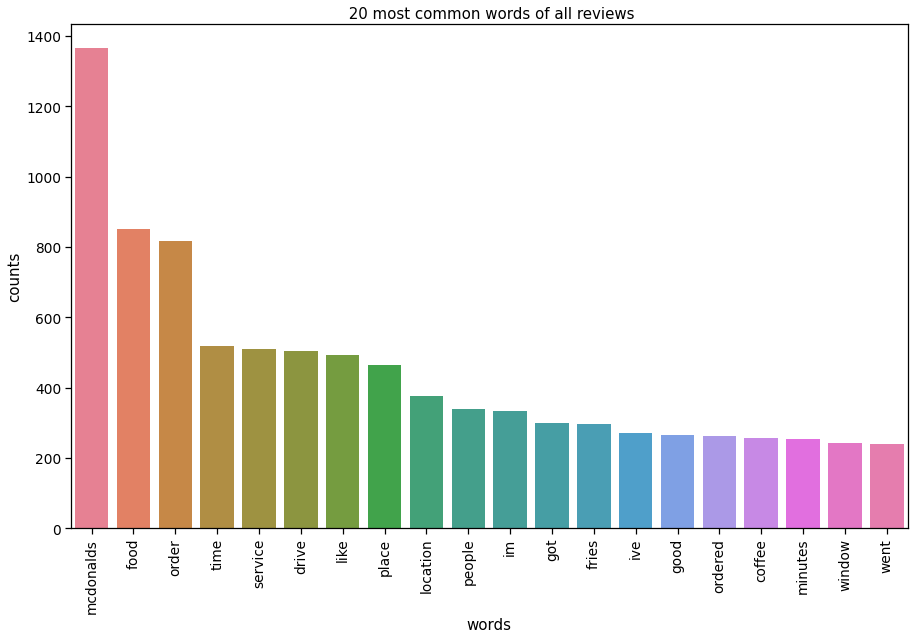

In [109]:
"""Code copyright: Vrije Universiteit Amsterdam"""

def plot_n_most_common_words(count_data, count_vectorizer, n, name):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title=f' {n} most common words of {name} reviews')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(reviews['review'])

# Visualise the n most common words
plot_n_most_common_words(count_data, count_vectorizer, 20, 'all')

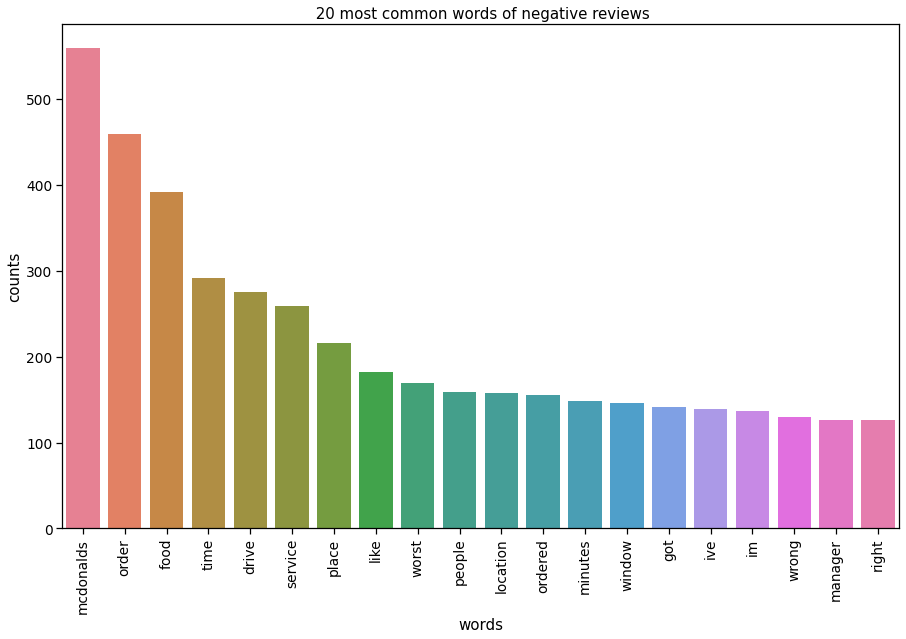

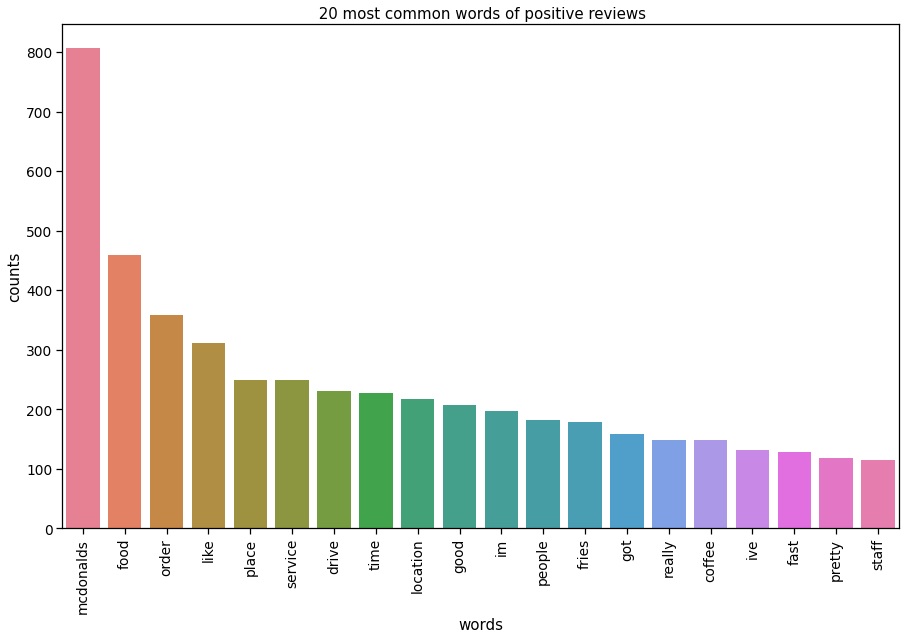

In [110]:
# Fit and transform the processed titles
count_vectorizer_negative = CountVectorizer(stop_words='english')
count_data_negative = count_vectorizer_negative.fit_transform(negative_reviews['review'])
plot_n_most_common_words(count_data_negative, count_vectorizer_negative, 20, 'negative')

count_vectorizer_positive = CountVectorizer(stop_words='english')
count_data_positive = count_vectorizer_positive.fit_transform(positive_reviews['review'])
plot_n_most_common_words(count_data_positive, count_vectorizer_positive, 20, 'positive')

In [111]:
class LDA_constructor():

    def __init__(self, data, vectorizer, n_topics = 5, num_words = 10):
        self.data = data
        self.n_topics = n_topics
        self.num_words = num_words
        self.vectorizer = vectorizer
        self.model = ' '

    def fitLDA(self):
        lda = LDA(n_components=self.n_topics)
        self.model = lda.fit(self.data)
        return self.model

    def display_topics(self):
        words = self.vectorizer.get_feature_names()
        for i, topic in enumerate(self.model.components_):
            print(f'Topic {i}#: \n {[words[i] for i in topic.argsort()[:-self.num_words - 1:-1]]}')

    def create_visual(self):
        pyLDAvis.enable_notebook()
        warnings.simplefilter("ignore", DeprecationWarning)
        warnings.simplefilter("ignore", FutureWarning)
        LDAvis_prepared = sklearn_lda.prepare(self.model, self.data, self.vectorizer)
        return LDAvis_prepared

In [112]:
# Create lda with 3 topics
lda_3_topics = LDA_constructor(count_data, count_vectorizer, 3, 10)

lda_3_topics.fitLDA()
lda_3_topics.display_topics()
lda_3_topics.create_visual()

Topic 0#: 
 ['mcdonalds', 'food', 'order', 'service', 'time', 'like', 'im', 'drive', 'location', 'ive']
Topic 1#: 
 ['mcdonalds', 'food', 'order', 'place', 'time', 'drive', 'service', 'people', 'window', 'minutes']
Topic 2#: 
 ['mcdonalds', 'order', 'food', 'like', 'drive', 'location', 'service', 'place', 'time', 'people']


/Users/michaelmoor/opt/anaconda3/envs/Data Wrangling/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/michaelmoor/opt/anaconda3/envs/Data Wrangling/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/michaelmoor/opt/anaconda3/envs/Data Wrangling/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/michaelmoor/opt/anaconda3/envs/Data Wrangling/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative us

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.055974  0.015872       1        1  39.330807
2      0.012910 -0.052129       2        1  30.422952
0      0.043064  0.036257       3        1  30.246241, topic_info=           Term         Freq        Total Category  logprob  loglift
5299  mcdonalds  1176.000000  1176.000000  Default  30.0000  30.0000
7398       said   175.000000   175.000000  Default  29.0000  29.0000
8814       took   135.000000   135.000000  Default  28.0000  28.0000
4310        ice    94.000000    94.000000  Default  27.0000  27.0000
5378  mcnuggets    29.000000    29.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
3536      fries    66.033238   258.616875   Topic3  -5.6606  -0.1694
6356     people    63.678404   296.758850   Topic3  -5.6969  -0.3433
9433       went    53.915010   210.383588   Topic3  -5.8634  -0.1657
4966       line    52.614506   192.344559   Topic3  -5.8878  -0.1005
3202       fast    52.371343   194.677808   Topic3  -5.8924  -0.1172

[275 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
82        1  0.379578       15
82        2  0.512430       15
82        3  0.094894       15
159       2  0.942147    24hrs
207       2  0.090236      3rd
...     ...       ...      ...
9592      2  0.942202   worthy
9613      1  0.324661    wrong
9613      2  0.371041    wrong
9613      3  0.304784    wrong
9656      1  0.937858  yelpers

[416 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [113]:
# Create lda with 5 topics
lda_5_topics = LDA_constructor(count_data, count_vectorizer, 5, 10)

lda_5_topics.fitLDA()
lda_5_topics.display_topics()
lda_5_topics.create_visual()

Topic 0#: 
 ['food', 'mcdonalds', 'order', 'time', 'place', 'like', 'fries', 'service', 'minutes', 'location']
Topic 1#: 
 ['mcdonalds', 'order', 'time', 'drive', 'window', 'ordered', 'got', 'like', 'food', 'said']
Topic 2#: 
 ['mcdonalds', 'place', 'like', 'people', 'food', 'good', 'service', 'nice', 'im', 'order']
Topic 3#: 
 ['mcdonalds', 'drive', 'order', 'service', 'food', 'location', 'like', 'window', 'worst', 'im']
Topic 4#: 
 ['mcdonalds', 'service', 'coffee', 'food', 'order', 'like', 'customer', 'place', 'good', 'line']


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.041637 -0.004498       1        1  34.010266
3      0.039536 -0.002688       2        1  23.267584
1      0.026640  0.067226       3        1  17.153410
4     -0.005553 -0.078971       4        1  14.282336
2     -0.102259  0.018931       5        1  11.286404, topic_info=           Term         Freq        Total Category  logprob  loglift
7603    service   444.000000   444.000000  Default  30.0000  30.0000
2711      drive   441.000000   441.000000  Default  29.0000  29.0000
5299  mcdonalds  1185.000000  1185.000000  Default  28.0000  28.0000
1766     coffee   219.000000   219.000000  Default  27.0000  27.0000
9502     window   211.000000   211.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
3765        got    20.146319   262.759767   Topic5  -5.8620  -0.3866
8742       time    21.623472   458.638266   Topic5  -5.7912  -0.8729
1225  breakfast    16.936998   160.212320   Topic5  -6.0355  -0.0654
5032   location    18.594130   330.949138   Topic5  -5.9422  -0.6975
4635        ive    17.638997   240.160069   Topic5  -5.9949  -0.4296

[437 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
14        1  0.596371     10
14        2  0.185755     10
14        3  0.107542     10
14        4  0.087989     10
14        5  0.019553     10
...     ...       ...    ...
9613      1  0.357649  wrong
9613      2  0.312130  wrong
9613      3  0.227595  wrong
9613      4  0.058524  wrong
9613      5  0.039016  wrong

[919 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 5, 3])

In [114]:
""" TODO : Implement counter --> implemented
           Plot graphs for most common words --> implemented, but VU code is used.
           Apply LDA to entire data set --> implemented
           Possibly use machine learning to check if selected words are correctly labled positive or negative """



' TODO : Implement counter --> implemented\n           Plot graphs for most common words --> implemented, but VU code is used.\n           Apply LDA to entire data set --> implemented\n           Possibly use machine learning to check if selected words are correctly labled positive or negative '